# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [79]:
# import libraries
import pandas as pd
import nltk
import re
import sklearn as sk
import math

import pickle

from sqlalchemy import create_engine
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [45]:
nltk.download(["punkt", "wordnet", "stopwords", "averaged_perceptron_tagger"])

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Christoph\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [30]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table("MessageData", engine)
df.head()
X = df.message
Y = df.loc[:, "related":"direct_report"]

In [31]:
# Visualizations
df.head()


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df.message.str.len()

0         66
1         39
2         31
3        100
4         63
        ... 
26175    148
26176    136
26177    141
26178    191
26179    209
Name: message, Length: 26180, dtype: int64

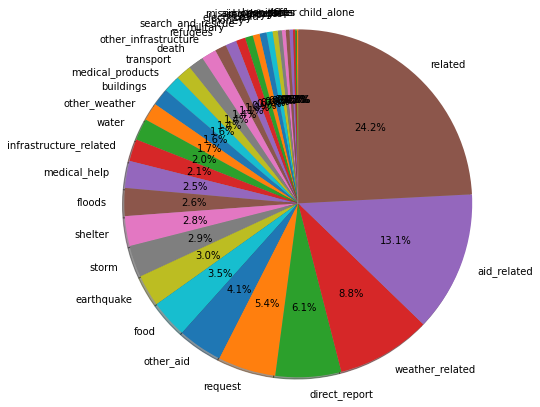

In [33]:
cat_number=df.loc[:, "related":"direct_report"].sum(axis=0).reset_index()
cat_number.columns=["category", "count"]
cat_number=cat_number.sort_values(by="count")

fig1, ax1 = plt.subplots()
ax1.pie(cat_number["count"], labels=cat_number["category"], autopct='%1.1f%%',
        shadow=True, radius=2, startangle=90)
plt.show()

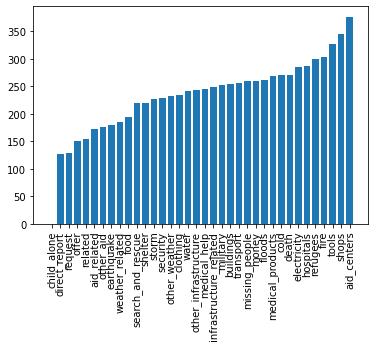

In [34]:
#letter_count=df.message.str.len()

df["letter_count"]=df.message.str.len()

cat_strlen_l=[]
categories=df.loc[:, "related":"direct_report"].columns
for cat in categories:
    avg_strlen=df[df[cat]==1].letter_count.mean()
    if(math.isnan(avg_strlen)):
        avg_strlen=0
    cat_strlen_l.append({"category": cat, "avg_strlen": avg_strlen})
cat_strlen=pd.DataFrame(cat_strlen_l)
cat_strlen=cat_strlen.sort_values("avg_strlen")

cat_strlen

fig2, ax2 = plt.subplots()
ax2.bar(x=cat_strlen.category, height=cat_strlen.avg_strlen)
plt.xticks(rotation=90)
plt.show()


### 2. Write a tokenization function to process your text data

In [46]:
def tokenize(text):
    found_urls=re.findall(url_regex, text)
    for pos in found_urls:
        text=text.replace(pos, "urlplaceholder")
    text=re.sub(r"[^a-zA-Z0-9]", " ", text) 
    text=text.lower()
    words=nltk.word_tokenize(text)
    
    #add1
    words_without_stops=[]
    for w in words:
        if not w in stopwords.words("english"):
            words_without_stops.append(w)
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for w in words:
        tok=lemmatizer.lemmatize(w).lower().strip()
        clean_tokens.append(tok)
        
    return clean_tokens
    

In [68]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):
    """
    Starting Verb Extractor class
    
    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if len(pos_tags)>0:
                first_word, first_tag = pos_tags[0]
            else:
                return False
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [69]:
class TextLengthExtractor(BaseEstimator, TransformerMixin):
    """
    Text length extractor
    
    This class extract the starting verb of a sentence,
    creating a new feature for the ML classifier
    """
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_len = X.str.len()
        return pd.DataFrame(X_len)

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [80]:
pipeline = Pipeline([
    ("features", FeatureUnion([
        ("nlp_pipeline", Pipeline([
            ("vect", CountVectorizer(tokenizer=tokenize)),
            ("tfidf", TfidfTransformer())
        ])),
        ("txt_len", TextLengthExtractor()),
        ("sve", StartingVerbExtractor())        
    ])),        
    ('moclf', OneVsRestClassifier(LinearSVC()))
])


In [65]:
sve = StartingVerbExtractor()
sve_result=sve.transform(X_train)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

pipeline.fit(X_train, Y_train)

c:\users\christoph\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\christoph\appdata\local\programs\python\python38\lib\site-packages\sklearn\multiclass.py:74: UserWarning: Label not 9 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('nlp_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  lowe

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [82]:
Y_pred=pd.DataFrame(pipeline.predict(X_test))
Y_pred.columns=Y_test.columns

In [83]:
# Gewichtete Accuracy - nicht ganz richtig

Y_test=Y_test.reset_index(drop=True)
'''acc_avg=0
for col in Y_test.columns:    
    weighted_accuracy_col=(Y_test[col]==Y_pred[col]).mean()*Y_test.mean()[col]
    acc_avg=acc_avg+weighted_accuracy_col
    #print(col, ": ", accuracy_col)
print("Avg. accuracy: ", acc_avg/len(Y_test.columns))    '''

'acc_avg=0\nfor col in Y_test.columns:    \n    weighted_accuracy_col=(Y_test[col]==Y_pred[col]).mean()*Y_test.mean()[col]\n    acc_avg=acc_avg+weighted_accuracy_col\n    #print(col, ": ", accuracy_col)\nprint("Avg. accuracy: ", acc_avg/len(Y_test.columns))    '

In [85]:
# Average accuracy

print((Y_pred==Y_test).mean().mean())

0.9123765667883317


In [86]:
X_train.str.len()

16918    152
24135    174
12630    134
10157    129
16595     60
        ... 
21575    101
5390      31
860      192
15795    200
23654    196
Name: message, Length: 18326, dtype: int64

In [87]:
(Y_pred==Y_test).mean().sort_values()

medical_products          0.209320
medical_help              0.563407
aid_related               0.733639
weather_related           0.821874
related                   0.828368
direct_report             0.865801
other_aid                 0.872676
request                   0.896359
infrastructure_related    0.929463
floods                    0.932646
storm                     0.934174
food                      0.935956
shelter                   0.938121
other_weather             0.938757
water                     0.942959
buildings                 0.946906
earthquake                0.951872
other_infrastructure      0.953909
transport                 0.954036
death                     0.960148
refugees                  0.962058
military                  0.966514
search_and_rescue         0.971734
money                     0.975427
cold                      0.976700
security                  0.980265
electricity               0.981029
aid_centers               0.985740
clothing            

In [78]:
for col in Y_test.columns:
    print(col)
    report=classification_report(Y_test[col], Y_pred[col])
    print(report)

related
              precision    recall  f1-score   support

           0       0.77      0.28      0.41      1869
           1       0.81      0.97      0.89      5985

    accuracy                           0.81      7854
   macro avg       0.79      0.63      0.65      7854
weighted avg       0.80      0.81      0.77      7854

request
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6512
           1       0.90      0.42      0.57      1342

    accuracy                           0.89      7854
   macro avg       0.90      0.71      0.76      7854
weighted avg       0.89      0.89      0.88      7854

offer
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7816
           1       0.00      0.00      0.00        38

    accuracy                           1.00      7854
   macro avg       0.50      0.50      0.50      7854
weighted avg       0.99      1.00      0.99      785

c:\users\christoph\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7747
           1       0.56      0.09      0.16       107

    accuracy                           0.99      7854
   macro avg       0.77      0.55      0.58      7854
weighted avg       0.98      0.99      0.98      7854

money
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7675
           1       0.86      0.03      0.06       179

    accuracy                           0.98      7854
   macro avg       0.92      0.52      0.53      7854
weighted avg       0.98      0.98      0.97      7854

missing_people
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7774
           1       0.00      0.00      0.00        80

    accuracy                           0.99      7854
   macro avg       0.49      0.50      0.50      7854
weighted avg       0.98      0.99      0.98      7854

In [15]:
'''for col in Y_test.columns:
    print(col)
    print(precision_recall_fscore_support(Y_test[col], Y_pred[col]))
    '''

'for col in Y_test.columns:\n    print(col)\n    print(precision_recall_fscore_support(Y_test[col], Y_pred[col]))\n    '

In [16]:
'''Y_pred.water.value_counts()
print(sk.__version__)'''
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000001E41F6E8F70>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('moclf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                          ccp_alpha=0.0,
                                                          class_weight=None,
                                                          criterion='gini',
                                                          max_de

### 6. Improve your model
Use grid search to find better parameters. 

In [17]:
'''parameters = {
    "moclf__estimator__criterion": ["gini", "entropy"],
    "moclf__estimator__max_depth": [5, 10, None]    
}

cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, Y_train)

Y_pred_gs=pd.DataFrame(cv.predict(X_test))'''

KeyboardInterrupt: 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [ ]:
Y_pred_gs.columns=Y_test.columns

In [ ]:
for col in Y_test.columns:
    print(col)
    report=classification_report(Y_test[col], Y_pred_gs[col])
    print(report)

In [ ]:
Y_test=Y_test.reset_index(drop=True)
acc_avg_gs=0
for col in Y_test.columns:    
    accuracy_col_gs=(Y_test[col]==Y_pred_gs[col]).mean()
    acc_avg_gs=acc_avg_gs+accuracy_col_gs
    #print(col, ": ", accuracy_col_gs)
print("Avg. accuracy: ", acc_avg_gs/len(Y_test.columns))  

In [ ]:
print(cv.best_params_)

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [ ]:
'''file = open("pickled_model.p", "wb")
s = pickle.dump(cv, file)
file.close()'''

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.